In [118]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install einx
    !pip install graphviz
    !pip install torchview
    !git clone https://github.com/akmayer/HelloWorldTransformer.git
    savedModelPath = "HelloWorldTransformer/savedTransformer.pt"
else:
    print("Not running in Google Colab. Skipping installation and cloning.")
    savedModelPath = "savedTransformer.pt"


Not running in Google Colab. Skipping installation and cloning.


In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einx
import random
from torch.utils.data import Dataset, DataLoader

def genList(listSize):
        return [(-1 if random.randint(0, 1) else random.random()) for x in range(listSize)]

def genAnswerKey(inputList):
    answerKeyList = []
    for val in inputList:
        numLessThanVal = 0
        for otherVal in inputList:
            if otherVal < val and otherVal > 0:
                numLessThanVal += 1
        answerKeyList.append(numLessThanVal)
    return answerKeyList


class ListDataset(Dataset):
    def __init__(self, listSize, datasetSize):
        self.datasetSize = datasetSize
        self.listSize = listSize
        self.allLists = [genList(self.listSize) for idx in range(self.datasetSize)]
        self.allAnswerKeys = [genAnswerKey(inputList) for inputList in self.allLists]

    def __len__(self):
        return self.datasetSize

    def __getitem__(self, idx):
        return torch.tensor(self.allLists[idx]).float(), torch.tensor(self.allAnswerKeys[idx]).float()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

basicDataset = ListDataset(3, 100)
sampleLoader = DataLoader(basicDataset, batch_size=1, shuffle=True)
sampleInputTensor, sampleAnswerKey = next(iter(sampleLoader))
print(sampleInputTensor)
print(sampleAnswerKey)

tensor([[-1.0000,  0.7272,  0.9370]])
tensor([[0., 0., 1.]])


In [120]:

import einx.nn.torch as einn
# Transform a (B, L) list to a (B, L, d_emb)
class Stem(nn.Module):
    def __init__(self, embeddingDim):
        super().__init__()
        self.norm = einn.Norm("b [c]")
        self.linearToEmbDim = nn.Linear(1, embeddingDim)
        self.gelu = nn.GELU()
        

    # X expected to be a (B, L) list
    def forward(self, x):
        x = self.norm(x)
        x = einx.rearrange("b c -> b c 1", x)
        x = self.linearToEmbDim(x)
        x = self.gelu(x)
        return x


stem = Stem(4)
sampleEmb = stem(sampleInputTensor)
print(sampleEmb.shape)

torch.Size([1, 3, 4])


In [121]:
import torch


keyDim = 2

sampleQuery = torch.tensor([
    [
        [0., 1],
        [1, 0],
        [1, 1]
    ]
])

sampleKey = torch.tensor([
    [
        [1., 0],
        [0, 1],
        [1, 1]
    ]
])

# Perform attention from all queries to all keys
dotProd = einx.dot("b q [d], b k [d] -> b q k", sampleQuery, sampleKey)
print(dotProd)

softMaxPerQuery = einx.softmax("b q [k]", dotProd / keyDim)
print(softMaxPerQuery)

sampleValDeltas = torch.tensor([
    [
        [2., 0],
        [0, 1],
        [1, 0]
    ]
])

# Each value is associated with the key that outputted that value so we do a matrix multiply across that key dimension to get the weighted sums 
# of each value embedding for each query:
appliedAttentionWeights = einx.dot("b q [k], b [k] h -> b q h", softMaxPerQuery, sampleValDeltas)

print(appliedAttentionWeights)

tensor([[[0., 1., 1.],
         [1., 0., 1.],
         [1., 1., 2.]]])
tensor([[[0.2327, 0.3837, 0.3837],
         [0.3837, 0.2327, 0.3837],
         [0.2741, 0.2741, 0.4519]]])
tensor([[[0.8490, 0.3837],
         [1.1510, 0.2327],
         [1.0000, 0.2741]]])


In [122]:
class AttentionHead(nn.Module):
    def __init__(self, emb_dim, head_size):
        super().__init__()
        self.keyMap = nn.Linear(emb_dim, head_size, bias=False)
        self.queryMap = nn.Linear(emb_dim, head_size, bias=False)
        self.valueDownMap = nn.Linear(emb_dim, head_size, bias=False)
        self.valueUpMap = nn.Linear(head_size, emb_dim, bias=False)

    def forward(self, x):
        # (B, C, emb_dim)
        key = self.keyMap(x) # (B, C, head_size)
        query = self.queryMap(x) # (B, C, head_size)
        valueDown = self.valueDownMap(x) # (B, C, head_size)

        # Self-attention, pairwise dot-prod all queries to all keys then softmax
        attentionDotProd = einx.dot("b q [d], b k [d] -> b q k", query, key) # (B, C, C)
        softMaxPerQuery = einx.softmax("b q [k]", attentionDotProd / np.sqrt(keyDim))
        # Take the weighted sum of the valueDown heads for each channel, where each channel corresponds to 
        appliedAttentionWeights = einx.dot("b q [k], b [k] h -> b q h", softMaxPerQuery, valueDown) # (B C head_size)

        embDelta = self.valueUpMap(appliedAttentionWeights) # (B, C, emb_dim)

        return embDelta, softMaxPerQuery

emb_dim = 4
batchSize = 1
numChannels = 3
head_size = 2

atHead = AttentionHead(emb_dim, head_size)
atHead(sampleEmb)[0]

tensor([[[-0.0556, -0.0076,  0.0241,  0.0462],
         [-0.0562, -0.0074,  0.0243,  0.0465],
         [-0.0565, -0.0074,  0.0244,  0.0467]]], grad_fn=<UnsafeViewBackward0>)

In [123]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.head_size = emb_dim // num_heads
        self.attention_heads = nn.ModuleList([AttentionHead(emb_dim, self.head_size) for _ in range(num_heads)])
        
    
    def forward(self, x):
        perHeadEmbDeltas = []
        perHeadAttentions = []
        for head in self.attention_heads:
            headEmbeddingDelta, headAttention = head(x)
            perHeadEmbDeltas.append(headEmbeddingDelta)
            perHeadAttentions.append(headAttention)
        perHeadAttentions = torch.stack(perHeadAttentions, dim=1)
        allHeadEmbDelta = torch.stack(perHeadEmbDeltas, dim=0).sum(dim=0)
        return allHeadEmbDelta, perHeadAttentions

emb_dim = 4
num_heads = 2
multiHeadedAtt = MultiHeadedAttention(emb_dim, num_heads)
multiHeadedAtt(sampleEmb)[0]

tensor([[[ 0.1006, -0.0767, -0.0138,  0.0072],
         [ 0.1005, -0.0764, -0.0127,  0.0085],
         [ 0.1001, -0.0762, -0.0121,  0.0091]]], grad_fn=<SumBackward1>)

In [124]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.attention = MultiHeadedAttention(emb_dim, num_heads)
        self.feedforward_nonlinear = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            nn.GELU(),
            nn.Linear(emb_dim * 4, emb_dim)
        )
        self.norm = nn.LayerNorm(emb_dim)
    def forward(self, x):
        attentionOutput, attentionWeights = self.attention(x)
        x = x + attentionOutput
        x = x + self.feedforward_nonlinear(x)
        x = self.norm(x)
        return x, attentionWeights

block = TransformerBlock(emb_dim, num_heads)
block(sampleEmb)[0]

tensor([[[ 1.2931,  0.0621,  0.1604, -1.5157],
         [-1.3530,  1.4702, -0.0561, -0.0612],
         [-1.4704,  1.2768, -0.2100,  0.4036]]],
       grad_fn=<NativeLayerNormBackward0>)

In [125]:
emb_dim = 32
num_heads = 8
num_blocks = 4

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = Stem(emb_dim)

        self.transformerBlocks = nn.ModuleList([TransformerBlock(emb_dim, num_heads) for _ in range(num_blocks)])

        self.output = nn.Linear(emb_dim, 1)

    def forward(self, x):
        allAttentionWeights = []
        allEmbeddings = []
        x = self.stem(x)
        allEmbeddings.append(x)
        for block in self.transformerBlocks:
            blockOutput, attentionWeights = block(x)
            x = blockOutput
            allEmbeddings.append(x)
            allAttentionWeights.append(attentionWeights)
        x = self.output(x)
        return x.squeeze(-1), tuple(allAttentionWeights), tuple(allEmbeddings)
        
sampleInputTensor = next(iter(sampleLoader))[0]
sampleTransformer = Transformer()
sampleTransformer(sampleInputTensor)[0].shape

torch.Size([1, 3])

In [126]:

transformer = Transformer()

trainDataset = ListDataset(10, 1000)
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
testDataset = ListDataset(10, 1000)
testLoader = DataLoader(testDataset, batch_size=256, shuffle=True)

inputTensor, targetTensor = next(iter(trainLoader))
print(inputTensor.shape)
transformer(inputTensor)[0].shape

torch.Size([64, 10])


torch.Size([64, 10])

In [131]:
from torch.optim.lr_scheduler import CosineAnnealingLR

n_epochs = 100
initialLearningRate = 0.003

model = Transformer()

optimizer = torch.optim.Adam(model.parameters(), lr = initialLearningRate)
scheduler = CosineAnnealingLR(optimizer, n_epochs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    model(next(iter(trainLoader))[0].to(device))

criterion = nn.L1Loss()

if retrainModel := False:
    for epoch in range(n_epochs):
        runningLoss = 0
        for inputTensor, targetTensor in trainLoader:
            model.zero_grad()
            pred, _, _ = model(inputTensor.to(device))
            loss = criterion(pred, targetTensor.to(device))
            loss.backward()
            runningLoss += loss.item() * inputTensor.shape[0]
            optimizer.step()
        scheduler.step()
    
        runningTestLoss = 0
        for inputTensor, targetTensor in testLoader:
            with torch.no_grad():
                pred, _, _ = model(inputTensor.to(device))
                loss = criterion(pred, targetTensor.to(device))
                runningTestLoss += loss.item() * inputTensor.shape[0]
        if epoch % 10 == 0:
            print(f"Epoch {epoch:< 4}Train Loss{round(runningLoss / len(trainDataset), 3):< 10}TestLoss{round(runningTestLoss / len(testDataset), 3):< 10}")
else:
    model.load_state_dict(torch.load(savedModelPath))


In [132]:
inp, t = next(iter(trainLoader))
def parseTensor(tensor):
    return '\t'.join([f"{x.item():.2f}" for x in tensor])
print("Input List:")
print(parseTensor(inp[0]))
print("True Target List:")
print(parseTensor(t[0]))
print("Predicted List:")
print(parseTensor(model(inp.to(device))[0][0]))


print()
print()
inp = torch.tensor([[0.1, 0.2, 0.3, 0.4, 0.5, -1, -1, -1, -1, -1]])
trueTarget = torch.tensor(genAnswerKey(inp[0]))
print("An In Distribution Input:")
print(parseTensor(inp[0]))
print("True Target:")
print(parseTensor(trueTarget))
print("Predictd List:")
print(parseTensor(model(inp.to(device))[0][0]))


print()
print()
inp = torch.tensor([[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, -1, -1, -1]])
trueTarget = torch.tensor(genAnswerKey(inp[0]))
print("An Out Of Distribution Input:")
print(parseTensor(inp[0]))
print("True Target:")
print(parseTensor(trueTarget))
print("Predictd List:")
print(parseTensor(model(inp.to(device))[0][0]))


print()
print()
inp = torch.tensor([[0.9, 0.95, 0.975, 0.99, 0.995, 0.9975, 0.9999, -1, -1, -1]])
trueTarget = torch.tensor(genAnswerKey(inp[0]))
print("A Pathological Input:")
print(inp[0])
print("True Target:")
print(parseTensor(trueTarget))
print("Predictdd List:")
print(parseTensor(model(inp.to(device))[0][0]))

Input List:
-1.00	0.30	0.98	0.22	0.90	-1.00	-1.00	0.40	-1.00	-1.00
True Target List:
0.00	1.00	4.00	0.00	3.00	0.00	0.00	2.00	0.00	0.00
Predicted List:
0.00	0.99	3.99	0.00	2.98	0.00	0.00	1.99	0.00	0.00


An In Distribution Input:
0.10	0.20	0.30	0.40	0.50	-1.00	-1.00	-1.00	-1.00	-1.00
True Target:
0.00	1.00	2.00	3.00	4.00	0.00	0.00	0.00	0.00	0.00
Predictd List:
0.00	1.02	2.01	3.00	4.02	-0.00	-0.00	-0.00	-0.00	-0.00


An Out Of Distribution Input:
0.50	0.60	0.70	0.80	0.90	0.95	0.97	-1.00	-1.00	-1.00
True Target:
0.00	1.00	2.00	3.00	4.00	5.00	6.00	0.00	0.00	0.00
Predictd List:
0.00	0.98	1.99	2.98	4.02	5.05	5.99	0.00	0.00	0.00


A Pathological Input:
tensor([ 0.9000,  0.9500,  0.9750,  0.9900,  0.9950,  0.9975,  0.9999, -1.0000,
        -1.0000, -1.0000])
True Target:
0.00	1.00	2.00	3.00	4.00	5.00	6.00	0.00	0.00	0.00
Predictdd List:
0.01	1.24	2.39	3.53	4.40	4.98	5.58	0.00	0.00	0.00


In [133]:
from torch.optim.lr_scheduler import CosineAnnealingLR

class DumbModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dumbLin = nn.Sequential(
            nn.Linear(10, 64),
            nn.GELU(),
            nn.Linear(64,8),
            nn.GELU(),
            nn.Linear(8,10)
        )
    def forward(self, x):
        return self.dumbLin(x)

n_epochs = 200
initialLearningRate = 0.03

dumbModel = DumbModel()

optimizer = torch.optim.Adam(dumbModel.parameters(), lr = initialLearningRate)
scheduler = CosineAnnealingLR(optimizer, n_epochs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dumbModel.to(device)

criterion = nn.L1Loss()

for epoch in range(n_epochs):
    runningLoss = 0
    for inputTensor, targetTensor in trainLoader:
        dumbModel.zero_grad()
        pred = dumbModel(inputTensor.to(device))
        loss = criterion(pred, targetTensor.to(device))
        loss.backward()
        runningLoss += loss.item() * inputTensor.shape[0]
        optimizer.step()
    scheduler.step()

    runningTestLoss = 0
    for inputTensor, targetTensor in testLoader:
        with torch.no_grad():
            pred = dumbModel(inputTensor.to(device))
            loss = criterion(pred, targetTensor.to(device))
            runningTestLoss += loss.item() * inputTensor.shape[0]
    if epoch % 25 == 0:
        print(f"Epoch {epoch:< 7}Train Loss{round(runningLoss / len(trainDataset), 3):< 10}TestLoss{round(runningTestLoss / len(testDataset), 2):< 10}")


Epoch  0     Train Loss 1.079    TestLoss 0.96     
Epoch  25    Train Loss 0.542    TestLoss 0.56     
Epoch  50    Train Loss 0.487    TestLoss 0.53     
Epoch  75    Train Loss 0.448    TestLoss 0.51     
Epoch  100   Train Loss 0.429    TestLoss 0.5      
Epoch  125   Train Loss 0.405    TestLoss 0.49     
Epoch  150   Train Loss 0.385    TestLoss 0.48     
Epoch  175   Train Loss 0.375    TestLoss 0.48     


In [134]:
inp, t = next(iter(trainLoader))
def parseTensor(tensor):
    return '\t'.join([f"{x.item():.2f}" for x in tensor])
print("Input List:")
print(parseTensor(inp[0]))
print("True Target List:")
print(parseTensor(t[0]))
print("Predicted List:")
print(parseTensor(dumbModel(inp.to(device))[0]))


print()
print()
inp = torch.tensor([[0.1, 0.2, 0.3, 0.4, 0.5, -1, -1, -1, -1, -1]])
trueTarget = torch.tensor(genAnswerKey(inp[0]))
print("An In Distribution Input:")
print(parseTensor(inp[0]))
print("True Target:")
print(parseTensor(trueTarget))
print("Predictd List:")
print(parseTensor(dumbModel(inp.to(device))[0]))


print()
print()
inp = torch.tensor([[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, -1, -1, -1]])
trueTarget = torch.tensor(genAnswerKey(inp[0]))
print("An Out Of Distribution Input:")
print(parseTensor(inp[0]))
print("True Target:")
print(parseTensor(trueTarget))
print("Predictd List:")
print(parseTensor(dumbModel(inp.to(device))[0]))


print()
print()
inp = torch.tensor([[0.9, 0.95, 0.975, 0.99, 0.995, 0.9975, 0.9999, -1, -1, -1]])
trueTarget = torch.tensor(genAnswerKey(inp[0]))
print("A Pathological Input:")
print(inp[0])
print("True Target:")
print(parseTensor(trueTarget))
print("Predictdd List:")
print(parseTensor(dumbModel(inp.to(device))[0]))

Input List:
-1.00	0.41	-1.00	-1.00	0.96	0.03	-1.00	-1.00	-1.00	0.12
True Target List:
0.00	2.00	0.00	0.00	3.00	0.00	0.00	0.00	0.00	1.00
Predicted List:
-0.06	1.09	0.00	0.00	3.18	0.66	0.00	-0.00	-0.01	-0.11


An In Distribution Input:
0.10	0.20	0.30	0.40	0.50	-1.00	-1.00	-1.00	-1.00	-1.00
True Target:
0.00	1.00	2.00	3.00	4.00	0.00	0.00	0.00	0.00	0.00
Predictd List:
1.45	2.10	1.97	0.00	3.41	0.71	0.00	-0.04	-0.03	-0.09


An Out Of Distribution Input:
0.50	0.60	0.70	0.80	0.90	0.95	0.97	-1.00	-1.00	-1.00
True Target:
0.00	1.00	2.00	3.00	4.00	5.00	6.00	0.00	0.00	0.00
Predictd List:
0.23	2.27	0.69	0.63	5.58	1.17	3.78	0.00	0.00	0.01


A Pathological Input:
tensor([ 0.9000,  0.9500,  0.9750,  0.9900,  0.9950,  0.9975,  0.9999, -1.0000,
        -1.0000, -1.0000])
True Target:
0.00	1.00	2.00	3.00	4.00	5.00	6.00	0.00	0.00	0.00
Predictdd List:
2.48	4.80	0.48	0.54	4.30	0.91	3.22	0.00	0.00	0.00


In [99]:
model.eval()
sampleInputs, sampleOutputs = next(iter(trainLoader))
sampleInputs = sampleInputs[0]
attention = model(sampleInputs.to(device).unsqueeze(0))[-1]

In [100]:
torch.save(model.state_dict(), "savedTransformer.pt")

In [101]:
from torchview import draw_graph
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin\\'
folderName = "img"
model_graph = draw_graph(model, input_size=(64, 10), device=device, expand_nested=True, depth=2)
model_graph.visual_graph.node_attr["fontname"] = "Helvetica"
model_graph.visual_graph.render(f"{folderName}/transformerArchDepth2")
model_graph = draw_graph(model, input_size=(64, 10), device=device, expand_nested=True, depth=3)
model_graph.visual_graph.node_attr["fontname"] = "Helvetica"
model_graph.visual_graph.render(f"{folderName}/transformerArchDepth3")
model_graph = draw_graph(model, input_size=(64, 10), device=device, expand_nested=True, depth=4)
model_graph.visual_graph.node_attr["fontname"] = "Helvetica"
model_graph.visual_graph.render(f"{folderName}/transformerArchDepth4")

'img\\transformerArchDepth4.pdf'

In [102]:
model.eval()
model.to(device)
sampleInputs, sampleOutputs = next(iter(trainLoader))
sampleInputs = sampleInputs[0]
attention = model(sampleInputs.to(device).unsqueeze(0))[1]
#!pip install bertviz
from bertviz import head_view, model_view

head_view(attention, [str(x) for x in sampleInputs])


<IPython.core.display.Javascript object>

In [103]:
model_view(attention, [str(x) for x in sampleInputs])

<IPython.core.display.Javascript object>

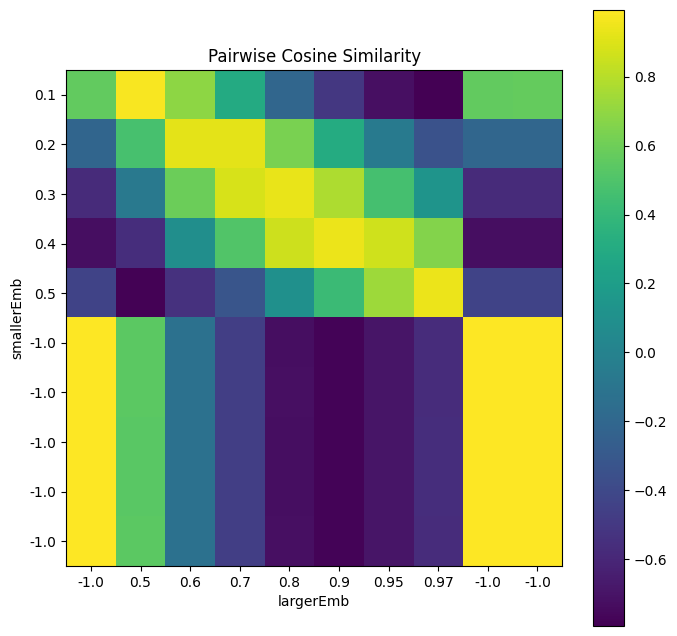

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

inpSmall = torch.tensor([[0.1, 0.2, 0.3, 0.4, 0.5, -1, -1, -1, -1, -1]])
predSmall, _, smallEmbeddings = model(inpSmall.to(device))


inpLarger = torch.tensor([[-1, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, -1, -1]])
predLarger, _, largeEmbeddings = model(inpLarger.to(device))

embeddingIdx = 3
lastSmallEmbeddings = smallEmbeddings[embeddingIdx].squeeze()
lastLargeEmbeddings = largeEmbeddings[embeddingIdx].squeeze()
lastSmallEmbeddings.shape


# Create two random tensors of shape (10, 32)
tensor_a = lastSmallEmbeddings.detach().cpu().numpy()
tensor_b = lastLargeEmbeddings.detach().cpu().numpy()

# Calculate the pairwise cosine similarity
cosine_sim_matrix = cosine_similarity(tensor_a, tensor_b)

# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(cosine_sim_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Pairwise Cosine Similarity')
plt.ylabel('smallerEmb')
plt.xlabel('largerEmb')
plt.yticks(np.arange(10), labels=[str(round(x.item(), 2)) for x in inpSmall[0]])
plt.xticks(np.arange(10), labels=[str(round(x.item(), 2)) for x in inpLarger[0]])
plt.grid(False)
plt.show()
